# Import

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib
matplotlib.__version__

'3.0.0'

In [5]:
np.__version__, pd.__version__

('1.15.2', '0.23.4')

# Dataset:

In [6]:
from sklearn.datasets import california_housing

data = california_housing.fetch_california_housing()

X = data['data']
y = data['target']
columns = data['feature_names']

train_df = pd.DataFrame(X, index=np.arange(len(X)), columns=columns)
train_df['target'] = y
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# 1) Initialize:

In [309]:
class SWMat(object):
    def __init__(self, plt, figsize=(10, 7)):
        """
        This class initializes your plot with some base aesthetics that can be set before plotting, initially.
        
        Parameters:
            plt: matplotlib.pyplot
                Pass in this during every cell execution to initialize current figure.
        """
        if plt is not None:
            self._plt = plt                                     # matplotlib.pyplot
            #self._plt.cla()
            self._figsize = figsize
            self._figsize_max = max(self._figsize)
            self._fig = self._plt.figure(figsize=self._figsize) # initialize figure size
            self._ax = self._plt.gca()                          # get current axis (gca)
            self._dpi = self._fig.dpi
            self._rc = self._plt.rc
        else:
            print("Error: Not able to initialize. You need to pass in matplotlib.pyplot.")
            return "Error: Not able to initialize. You need to pass in matplotlib.pyplot."
        
        ########### Initial Settings ###########
        import math
        self._ax.tick_params(length=self._figsize_max/1.3,
                             width=self._figsize_max/7,
                             labelsize=math.log2(self._figsize_max)*4, colors="gray")
        
        # Remove top and left spines:
        self._ax.spines['right'].set_visible(False)
        self._ax.spines['top'].set_visible(False)
        
        # Change color of bottom and left spines, ticks and labels to 'gray'
        self._ax.spines['bottom'].set_color('gray')
        self._ax.spines['bottom'].set_linewidth(math.log2(self._figsize_max))
        self._ax.spines['bottom'].set_alpha(0.75)
        self._ax.spines['left'].set_color('gray')
        self._ax.spines['left'].set_linewidth(math.log2(self._figsize_max))
        self._ax.spines['left'].set_alpha(0.75)

        #self._ax.tick_params(axis='x', colors='gray')
        #self._ax.tick_params(axis='y', colors='gray')

        self._ax.yaxis.label.set_color('gray')
        self._ax.xaxis.label.set_color('gray')
        
        ########################################
        
        
    def _get_props(self, string):
        """
        """
        import re
        iter_ = re.finditer(r">", string)
        iter_ = [m.start(0) for m in iter_]

        assert len(iter_) == 1, "There is some problem parsing string. Maybe you have an extra '>' somewhere...?"
        iter_ = iter_[0]

        props = re.sub(' +', ' ', string[5:iter_].strip()) + " "
        string = string[iter_+1: ].strip()

        # Converting string props to dict props
        eqs = re.finditer("=", props)
        eqs = [m.start(0) for m in eqs]
        sps = re.finditer(" ", props)
        sps = [m.start(0) for m in sps]
        result = {}
        prev = 0
        for i in range(len(eqs)):
            attr_name = props[prev:eqs[i]]
            attr_value = props[eqs[i]+1:sps[i]][1:-1]
            result[attr_name] = attr_value
            prev = sps[i]+1

        props = result
        return string, props
        
    
    def _split_text(self, text, fontdict):
        """
        """
        import re
        
        start = re.finditer(r"(?<![\\])<", text)
        start = [m.start(0) for m in start]
        end = re.finditer(r"(?<![\\])>", text)
        end = [m.start(0) for m in end]
        
        assert len(start) == len(end), "You should escape <, > if not used to give props, like \< and \>."
        
        result = []
        if start[0] != 0:
            result.append((text[:start[0]], fontdict))
        for i in range(0, len(start), 2):
            s, e = start[i], end[i+1]
            result.append(self._get_props(text[start[i]:end[i+1]-6]))
            if i+2 < len(start):
                if end[i+1] != start[i+2]-1:
                    result.append((text[end[i+1]+1:start[i+2]].replace("\\>", ">").replace("\\<", "<"), fontdict))
        if end[-1]+1 != len(start):
            result.append((text[end[-1]+1:], fontdict))
        
        return result
    
    def _render_text(self, x, y, s, fontdict, is_raw_text, withdash, **kwargs):
        """
        """
        # https://stackoverflow.com/questions/5320205/matplotlib-text-dimensions
        renderer = self._fig.canvas.get_renderer()
        if is_raw_text:
            text = self._plt.text(x, y, s, ha='left', va='top', bbox={'boxstyle':'square,pad=0','fc':'None', 'lw':0},
                                  fontdict=fontdict, withdash=withdash, **kwargs)
            bbox = text.get_window_extent(renderer=renderer)
        else:
            text = self._plt.text(x, y, s, ha='left', va='top', bbox={'boxstyle':'square,pad=0','fc':'None', 'lw':0},
                                 **fontdict)
            bbox = text.get_window_extent(renderer=renderer)
            
        return bbox, text
        
    def text(self, s, position='out-upper-right', fontdict=None, withdash=False, x=None, y=None, **kwargs):
        """
        ** Call it after making your plot **
        This is a wrapper method to matplotlib's plt.text, adding some extra flexibility.
        
        Parameters:
                position: str 
                    Position of text. Possible positions are 'upper-right', 'upper-left', 'lower-left', 
                    'lower-right', 'upper-center', 'lower-center', 'out-upper-right', 'out-upper-left', 
                    'out-lower-left', 'out-lower-right', 'out-upper-center', 'out-lower-center'.
                
                s: str (directly passed to matplotlib's text method)
                    The text.
                fontdict: dictionary, optional, default: None (directly passed to matplotlib's text method)
                    A dictionary to override the default text properties. These will be applied to sub-texts
                    for which <prop> is not given.
                withdash: boolean, optional, default: False (directly passed to matplotlib's text method)
                    Creates a `~matplotlib.text.TextWithDash` instance instead of a `~matplotlib.text.Text` 
                    instance.
                x, y: scalars (directly passed to matplotlib's text method)
                    The position to place the text.
        Returns:
            x and y position on next line for current string (you can use it to continue text, if you change default props),
            and list of all sub-text plt.text objects for current string.
            
        """
        
        pos_dict = {
            'upper-right':     (.85, .95),
            'upper-left':      (.01, 1.0),
            'lower-left':      (.01, .15),
            'lower-right':     (.85, .15),
            'upper-center':    (.40, .95),
            'lower-center':    (.40, .15),
            'out-upper-right': (1.03, .95),
            'out-upper-left':  (-.5, .95), 
            'out-lower-left':  (-.3, .15),
            'out-lower-right': (1.03, .15),
            'out-upper-center':(.40, 1.3),
            'out-lower-center':(.40, -.2),
        }
        inv = self._ax.transData.inverted()
        if x is None and y is None: x, y = inv.transform(self._ax.transAxes.transform((pos_dict[position][0], 
                                                                                               pos_dict[position][1]))).tolist()
        text_x = self._ax.transData.transform((x, y))[0]
        text_y_max_h = 0
        
        strings_n_fonts = self._split_text(s, fontdict)
        
        newline = 0
        new_x, new_y = 0, 0
        i = 0
        result = []
        for string, font in strings_n_fonts:
            if len(string) < 1 or string == " ": continue
            if "\n" in string: newline = 1 
            if newline:
                if string[0] == "\n":
                    string = " " + string
                if string[-1] == "\n":
                    string = string + " "
                strs_ = string.split("\n")
                j = 0
                for s in strs_:
                    if j == 0:
                        bbox, t_ = self._render_text(new_x, new_y, s, font, font==fontdict, withdash, **kwargs)
                        if bbox.height > text_y_max_h: text_y_max_h = bbox.height
                        new_x, new_y = self._pixels_to_data(bbox, len(s), text_x, text_y_max_h, newline=True)
                        text_y_max_h = bbox.height
                    else:
                        bbox, t_ = self._render_text(new_x, new_y, s, font, font==fontdict, withdash, **kwargs)
                        text_y_max_h = bbox.height
                        new_x, new_y = self._pixels_to_data(bbox, len(s), text_x, text_y_max_h, newline=True)
                    j += 1
                    if s != " ":
                        result.append(t_)
            else:
                if i:
                    bbox, t_ = self._render_text(new_x, new_y, string, font, font==fontdict, withdash, **kwargs)
                    result.append(t_)
                    if bbox.height > text_y_max_h: text_y_max_h = bbox.height
                    new_x, new_y = self._pixels_to_data(bbox, len(string), text_x, text_y_max_h)
                else:
                    bbox, t_ = self._render_text(x, y, string, font, font==fontdict, withdash, **kwargs)
                    result.append(t_)
                    text_y_max_h = bbox.height
                    new_x, new_y = self._pixels_to_data(bbox, len(string), text_x, text_y_max_h)
            
            i += 1
            newline = 0
        
        return (new_x, new_y), result
    
    def _pixels_to_data(self, prev_bbox, length, text_x, max_h, newline=False):
        """
        """
        import math
        inv = self._ax.transData.inverted()
        
        y0, x1, y1 = prev_bbox.y0, prev_bbox.x1, prev_bbox.y1
        width, height = prev_bbox.width, prev_bbox.height
        
        res_x, res_y = None, None
        if newline:
            res_x = text_x
            if max_h > height:
                res_y = y0 - math.exp(math.sqrt(max_h))/8.0
            else:
                res_y = y0 + .5*height
        else:
            char_len = width/length
            res_x = x1 + char_len
            res_y = y1
        
        return inv.transform((res_x, res_y)).tolist()
    
    
    def hist(self, x, bins=None, highlight=None, normal_color="gray", highlight_color="#FF7200", annotate=True, 
             hide_y=False, **kwargs):
        """
        This is a wrapper function to matplotlib's pyplot.hist function.
        
        Parameters:
            highlight: list, array, int, optional
                Array of Box index or Patch index to highlight.
            normal_color, highlight_color: gray, orange(#FF7200)
                Color's for diffetentiting normal bins from highlighted bins. Default values are chosen by keeping
                color blindness in mind.
            hide_y: bool
                Weather to hide y-axis or not.
            annotate: bool
                Weather to annotate.
                
            x : (n,) array or sequence of (n,) arrays  (directly passed to matplotlib's hist)
                Input values, this takes either a single array or a sequence of
                arrays which are not required to be of the same length.
            bins : int or sequence or str, optional (directly passed to matplotlib's hist)
                If an integer is given, ``bins + 1`` bin edges are calculated and
                returned, consistent with `numpy.histogram`.
            ...
            **kwargs:      (directly passed to matplotlib's hist)
                Contains all params that matplotlib's hist function takes.
        
        Returns:
            Tuple of returned objs from matplotlib's hist function and objs of annotations.
        """
        import math
        
        if isinstance(highlight, int): highlight = [highlight]
        
        ##### Plot histogram with highlight #####
        if highlight is None:
            hist_plot = self._plt.hist(x, bins=bins, **kwargs)
            for i in range(len(hist_plot[2])):
                hist_plot[2][i].set_color(normal_color)
                hist_plot[2][i].set_alpha(0.9)
                hist_plot[2][i].set_ec('w')
        else:
            hist_plot = self._plt.hist(x, bins=bins, **kwargs)
            for i in range(len(hist_plot[2])):
                if i in highlight:
                    hist_plot[2][i].set_color(highlight_color)
                    hist_plot[2][i].set_alpha(1.0)
                    hist_plot[2][i].set_ec('w')
                else:
                    hist_plot[2][i].set_color(normal_color)
                    hist_plot[2][i].set_alpha(0.9)
                    hist_plot[2][i].set_ec('w')
        
        
        
        ##### Setting x-axis ticks and labels #####
        self._plt.xlim(min(hist_plot[1]), max(hist_plot[1]))
        
        if hasattr(x, 'name'): self._plt.xlabel(x.name, fontsize=math.log2(self._figsize_max)*5)
        if hide_y: self._ax.spines['bottom'].set_smart_bounds(True)
        else: self._ax.xaxis.set_label_coords(.05, -.1)
        
        ##### Setting y-axis ticks and labels #####
        annotations = []
        if hide_y:
            self._ax.yaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            
            if annotate:
                xs = []
                for i in range(1, len(hist_plot[1])): xs.append((hist_plot[1][i] + hist_plot[1][i-1])/2)
                hght = self._ax.get_ylim()[1] - self._ax.get_ylim()[0]
                bbox_props = {'boxstyle': 'round', 'pad': 0.5, 'facecolor': 'orange', 'edgecolor': 'orange', 'alpha': 0.6}
                arr_props = {'arrowstyle':"wedge,tail_width=0.5", 'alpha':0.6, 'color': 'orange'}
                if highlight is not None:
                    for h in highlight:
                        annotations.append(self._plt.annotate(str(int(hist_plot[0][h])), xy=(xs[h], hist_plot[0][h]),
                                           xytext=(xs[h], hist_plot[0][h]+.04*hght), ha='center', bbox=bbox_props,
                                           arrowprops=arr_props))
                else:
                    for i in range(len(hist_plot[0])):
                        annotations.append(self._plt.annotate(str(int(hist_plot[0][i])), xy=(xs[i], hist_plot[0][i]), 
                                           xytext=(xs[i], hist_plot[0][i]+.04*hght), ha='center', bbox=bbox_props,
                                           arrowprops=arr_props))
        else:
            self._plt.ylim(0, max(hist_plot[0])*1.1)

            self._plt.ylabel("Frequency", fontsize=math.log2(self._figsize_max)*5)
            if highlight is None:
                ytks = self._ax.get_yticks().tolist()
                self._plt.yticks(ytks, [str(int(tk)) for tk in ytks])
            else:
                if len(highlight) == 1:
                    ytks = self._ax.get_yticks().tolist()
                    ytks.append(hist_plot[0][highlight[0]])
                    self._plt.yticks(ytks, [str(int(tk)) for tk in ytks])

                    self._ax.get_yticklabels()[-1].set_color(highlight_color)

            self._ax.yaxis.set_label_coords(-.1, .8)
        
        return hist_plot, annotations
    
    def bar(self, cats, heights, width=0.8, plot_type="sidebyside", cat_labels=None, data_labels=None,
            highlight=None, highlight_type={"cat_type": "static", "data_type": "static"}, 
            highlight_color={"cat_color": "#4B4FF4", "data_color": "#FF7700"}, normal_color="gray", **kwargs):
        """
        Parameters:
            cats, heights: numpy.ndarray or list(1D array) or tuple
                Vertically stacked (row wise) sequences of scalars; Vertically stacked 1D arrays.
                'cats' are categories (encoded) and heights are measurement or frequency for each category.
            plot_type: str
                "stackedV", "stackedH", "stacked100%" or "sidebyside".
            cat_labels: list of str
                Label for each category in bar plot.
            data_labels: list of str
                Label for each data array, having length equal to cats.shape[0].
            highlight: dict
                As {"cat": [1, 3...], "data": 2}. Can contain any one of them as key too.
            highlight_type: dict
                "static" or "incrementalUp" or "IncrementalDown". As {"cat_type": "static", "data_type": "incremental"}. 
                Can contain any one of them as key too.
            normal_color: gray
                Color's for diffetentiting normal bins from highlighted bins. Default values are chosen by keeping
                color blindness in mind.
            highlight_color: dict
                As {"cat_color": "#4B4FF4", "data_color": "blue"}. Can contain any one of them as key too.
                ## Data color takes precedence. ##
            ...
            **kwargs:      (directly passed to matplotlib's hist)
                Contains all params that matplotlib's hist function takes.
        """
        import numpy as np
        import math
        
        if type(cats) == list or type(cats) == tuple:
            assert len(cats) == len(heights), "Number of points should be equal to number of heights given."
        else:
            assert cats.shape[0] == heights.shape[0], ('Number of diff. arrays given for bar plots should be equal to number of' 
                                                       ' arrays of heights, stacked vertically.')
            assert cats.shape[1] == heights.shape[1], ('Number of points in point\'s array(xs) should be equal to number of heights'
                                                       ' in each array.')
        
        if type(cats) == list or type(cats) == tuple:
            return self._plt.bar(cats, heights, width=width, align='center')
        elif cats.shape[0] == 1:
            return self._plt.bar(cats, heights, width=width, align='center')
        
        if "cat_color" in highlight_color.keys():
            cat_color = highlight_color['cat_color']
        else: cat_color = "gray"
        if "data_color" in highlight_color.keys():
            data_color = highlight_color['data_color']
        else: data_color = "gray"
        
        if "cat_type" in highlight_type.keys():
            cat_type = highlight_type['cat_type']
        else: cat_type = "static"
        if "data_type" in highlight_type.keys():
            data_type = highlight_type['data_type']
        else: data_type = "static"
        
        return_ = []
        if plot_type == "sidebyside":
            minor_xticks = []
            major_xticks = []
            minor_labels = []
            major_labels = []
            
            n_ = cats.shape[0]
            n_cat = cats.shape[1]
            
            one_cat_width = (1.1*width*n_ + width)
            last_strt_pt = one_cat_width * (n_cat)
            
            if cat_labels is not None: 
                for i in range(len(cats[0,:])): major_xticks.append(i*one_cat_width + one_cat_width*(float(n_-1)/n_)*0.63+width)
            if cat_labels is None:  
                for c in cats[0,:]: major_labels.append(c)
            else: 
                for c in cat_labels: major_labels.append(c)

            for i in range(n_):
                x = [(j+i*1.1*width) for j in np.arange(1, last_strt_pt, one_cat_width)]
                
                for x_t in x: minor_xticks.append(x_t+width*0.5)                
                for j in range(len(x)):
                    if data_labels is not None: minor_labels.append(data_labels[i])
                    
                height = heights[i,:].tolist()
                b_plt = self._plt.bar(x, height, width=width, align='edge')
                return_.append(b_plt)
                patches = b_plt.patches
                max_h = max(height)
                min_h = min(height)
                if highlight is not None:
                    for p in patches: p.set_color(normal_color)
                    if "cat" in highlight.keys():
                        if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                        for k, p in enumerate(patches):
                            if k in highlight['cat']:
                                p.set_color(cat_color)
                                if cat_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif cat_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                    if "data" in highlight.keys():
                        if type(highlight['data']) == int: highlight['data'] = [highlight['data']]
                        for k, p in enumerate(patches):
                            if i in highlight['data']: 
                                p.set_color(data_color)
                                if data_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif data_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                else:
                    for p in patches: p.set_color(normal_color)
            
            minor_l = len(minor_xticks)
            for mj in major_xticks: minor_xticks.append(mj)
            for mj in major_labels: minor_labels.append(mj)

            tks = self._plt.xticks(minor_xticks, minor_labels)
            lbs = self._ax.get_xticklabels()
            j = 0
            inv = self._ax.transAxes.inverted()
            for i in range(minor_l, len(minor_xticks)):
                lbs[i].set_fontsize(math.log2(self._figsize_max)*5)
                lbs[i].set_position((inv.transform((major_xticks[j], 10))[0], -0.08))
                j += 1
        elif plot_type == "stackedV":
            self._ax.yaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            self._ax.spines['bottom'].set_visible(False)
            self._ax.tick_params(length=0, width=0, labelsize=math.log2(self._figsize_max)*5, pad=10*width)
            _ax_ = self._ax.twinx()
            for pos in ['left', 'top', 'bottom']:
                _ax_.spines[pos].set_visible(False)
            _ax_.spines['right'].set_smart_bounds(True)
            _ax_.tick_params(length=self._figsize_max/1.3,
                                 width=self._figsize_max/7,
                                 labelsize=math.log2(self._figsize_max)*4, colors="gray")
            _ax_.spines['right'].set_color('gray')
            _ax_.spines['right'].set_linewidth(math.log2(self._figsize_max))
            _ax_.spines['right'].set_alpha(0.75)
            _ax_.yaxis.label.set_color('gray')
            
            n_ = cats.shape[0]
            n_cat = cats.shape[1]
            
            one_cat_width = 1.5*width
            last_strt_pt = one_cat_width * (n_cat)
            
            bottom = np.zeros((n_cat,))
            
            x = np.arange(1, last_strt_pt, one_cat_width)
            xtks = [tk+width/2 for tk in x]
            if cat_labels is not None: xlabel = cat_labels
            else: xlabel = [str(k) for k in cats[0,:]]
            
            for i in range(n_):
                height = heights[i,:]
                b_plt = self._plt.bar(x, height, width=width, bottom=bottom, align='edge')
                return_.append(b_plt)
                bottom = bottom + height
                patches = b_plt.patches
                max_h = max(height)
                min_h = min(height)
                if highlight is not None:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(1)
                    if "cat" in highlight.keys():
                        if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                        for k, p in enumerate(patches):
                            if k in highlight['cat']:
                                p.set_color(cat_color)
                                if cat_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif cat_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                    if "data" in highlight.keys():
                        if type(highlight['data']) == int: highlight['data'] = [highlight['data']]
                        for k, p in enumerate(patches):
                            if i in highlight['data']: 
                                p.set_color(data_color)
                                p.set_alpha(1.0)
                                if data_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif data_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                else:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(1)
                
                if data_labels is not None:
                    b1, b2 = patches[0].get_bbox(), patches[-1].get_bbox()
                    width_ = b1.width
                    y11, y12, y21, y22 = b1.y0, b1.y1, b2.y0, b2.y1
                    y11, y12 = y11+.2*width_, y12-.2*width_
                    y21, y22 = y21+.2*width_, y22-.2*width_
                    x1, x2 = b1.x0, b2.x1
                    x1, x2 = x1-.2*width_, x2+.2*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: self._plt.plot((x1, x1), (y11, y12), highlight_color['data_color'])#, (x2, x2), (y21, y22), highlight_color['data_color'])
                            else: self._plt.plot((x1, x1), (y11, y12), "gray")#, (x2, x2), (y21, y22), "gray")
                        else:
                            self._plt.plot((x1, x1), (y11, y12), "gray")#, (x2, x2), (y21, y22), "gray")
                    else:
                        self._plt.plot((x1, x1), (y11, y12), "gray")#, (x2, x2), (y21, y22), "gray")

                    mid1, mid2 = (b1.y1 + b1.y0)/2, (b2.y1 + b2.y0)/2
                    x1, x2 = x1-.15*width_-.1*width_*(len(data_labels[i])-1), x2+.05*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: 
                                self._plt.text(x1, mid1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'])
                                #self._plt.text(x2, mid2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'])
                            else: 
                                self._plt.text(x1, mid1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                                #self._plt.text(x2, mid2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                        else:
                            self._plt.text(x1, mid1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                            #self._plt.text(x2, mid2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                    else:
                        self._plt.text(x1, mid1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                        #self._plt.text(x2, mid2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray")
                    
                
            self._plt.xticks(xtks, xlabel)
            if highlight is not None:
                if "cat" in highlight.keys():
                    if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                    tks = self._ax.get_xticklabels()
                    for i in highlight['cat']:
                        tks[i].set_color(highlight_color['cat_color'])
        elif plot_type == "stackedH":
            #self._ax.xaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            #self._ax.spines['bottom'].set_visible(False)
            self._ax.tick_params(axis='y',length=0, width=0, labelsize=math.log2(self._figsize_max)*5, pad=10*width)
            self._ax.spines['bottom'].set_smart_bounds(True)
            
            n_ = cats.shape[0]
            n_cat = cats.shape[1]
            
            one_cat_width = 1.5*width
            last_strt_pt = one_cat_width * (n_cat)
            
            left = np.zeros((n_cat,))
            
            y = np.arange(1, last_strt_pt, one_cat_width)
            ytks = [tk+width/2 for tk in y]
            if cat_labels is not None: ylabel = cat_labels
            else: ylabel = [str(k) for k in cats[0,:]]
            
            for i in range(n_):
                height = heights[i,:]
                b_plt = self._plt.barh(y, width=height, height=width, left=left, align='edge')
                return_.append(b_plt)
                left = left + height
                patches = b_plt.patches
                max_h = max(height)
                min_h = min(height)
                if highlight is not None:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(.1)
                    if "cat" in highlight.keys():
                        if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                        for k, p in enumerate(patches):
                            if k in highlight['cat']:
                                p.set_color(cat_color)
                                if cat_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif cat_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                    if "data" in highlight.keys():
                        if type(highlight['data']) == int: highlight['data'] = [highlight['data']]
                        for k, p in enumerate(patches):
                            if i in highlight['data']: 
                                p.set_color(data_color)
                                p.set_alpha(1.0)
                                if data_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif data_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                else:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(1)
                
                if data_labels is not None:
                    b1, b2 = patches[0].get_bbox(), patches[-1].get_bbox()
                    width_ = b1.height
                    x11, x12, x21, x22 = b1.x0, b1.x1, b2.x0, b2.x1
                    x11, x12 = x11+.2*width_, x12-.2*width_
                    x21, x22 = x21+.2*width_, x22-.2*width_
                    y1, y2 = b1.y0, b2.y1
                    y1, y2 = y1-.15*width_, y2+.3*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: self._plt.plot((x21, x22), (y2, y2), highlight_color['data_color'])#,(x11, x12), (y1, y1), highlight_color['data_color'])
                            else: self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")
                        else:
                            self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")
                    else:
                        self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")

                    mid1, mid2 = (b1.x1 + b1.x0)/2, (b2.x1 + b2.x0)/2
                    y1, y2 = y1-.15*width_-.1*width_*(len(data_labels[i])-1), y2+.05*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: 
                                #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'], ha='center')
                                self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'], ha='center')
                            else: 
                                #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                                self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                        else:
                            #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                            self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                    else:
                        #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                        self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                    
                
            self._plt.yticks(ytks, ylabel)
            if highlight is not None:
                if "cat" in highlight.keys():
                    if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                    tks = self._ax.get_yticklabels()
                    for i in highlight['cat']:
                        tks[i].set_color(highlight_color['cat_color'])
        elif plot_type == "stacked100%":
            for i in range(1, heights.shape[1]):
                assert np.sum(heights[:,0]) == np.sum(heights[:,i]), "Every category should have same sum (of heights) to get 100% bar plot."
            #for i in range(heights.shape[1]):
            #    sum_ = np.sum(heights[:,i])
            #    heights[:, i] = heights[:, i]/float(sum_)
            
            #self._ax.xaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            #self._ax.spines['bottom'].set_visible(False)
            self._ax.tick_params(axis='y',length=0, width=0, labelsize=math.log2(self._figsize_max)*5, pad=10*width)
            self._ax.spines['bottom'].set_smart_bounds(True)
            
            n_ = cats.shape[0]
            n_cat = cats.shape[1]
            
            one_cat_width = 1.5*width
            last_strt_pt = one_cat_width * (n_cat)
            
            left = np.zeros((n_cat,))
            
            y = np.arange(1, last_strt_pt, one_cat_width)
            ytks = [tk+width/2 for tk in y]
            if cat_labels is not None: ylabel = cat_labels
            else: ylabel = [str(k) for k in cats[0,:]]
            
            for i in range(n_):
                height = heights[i,:]
                b_plt = self._plt.barh(y, width=height, height=width, left=left, align='edge')
                return_.append(b_plt)
                left = left + height
                patches = b_plt.patches
                max_h = max(height)
                min_h = min(height)
                if highlight is not None:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(.1)
                    if "cat" in highlight.keys():
                        if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                        for k, p in enumerate(patches):
                            if k in highlight['cat']:
                                p.set_color(cat_color)
                                if cat_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif cat_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                    if "data" in highlight.keys():
                        if type(highlight['data']) == int: highlight['data'] = [highlight['data']]
                        for k, p in enumerate(patches):
                            if i in highlight['data']: 
                                p.set_color(data_color)
                                p.set_alpha(1.0)
                                if data_type == "IncrementalUp": p.set_alpha(max(0.5, height[k]/max_h))
                                elif data_type == "IncrementalDown": p.set_alpha(max(0.5, min_h/height[k]))
                else:
                    for p in patches: 
                        p.set_color(normal_color)
                        p.set_ec("#FFFFFF")
                        p.set_lw(1)
                
                if data_labels is not None:
                    b1, b2 = patches[0].get_bbox(), patches[-1].get_bbox()
                    width_ = b1.height
                    x11, x12, x21, x22 = b1.x0, b1.x1, b2.x0, b2.x1
                    x11, x12 = x11+.2*width_, x12-.2*width_
                    x21, x22 = x21+.2*width_, x22-.2*width_
                    y1, y2 = b1.y0, b2.y1
                    y1, y2 = y1-.15*width_, y2+.3*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: self._plt.plot((x21, x22), (y2, y2), highlight_color['data_color'])#,(x11, x12), (y1, y1), highlight_color['data_color'])
                            else: self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")
                        else:
                            self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")
                    else:
                        self._plt.plot((x21, x22), (y2, y2), "gray")#, (x11, x12), (y1, y1), "gray")

                    mid1, mid2 = (b1.x1 + b1.x0)/2, (b2.x1 + b2.x0)/2
                    y1, y2 = y1-.15*width_-.1*width_*(len(data_labels[i])-1), y2+.05*width_
                    if highlight is not None:
                        if "data" in highlight.keys():
                            if i in highlight['data']: 
                                #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'], ha='center')
                                self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color=highlight_color['data_color'], ha='center')
                            else: 
                                #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                                self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                        else:
                            #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                            self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                    else:
                        #self._plt.text(mid1, y1, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
                        self._plt.text(mid2, y2, data_labels[i], fontsize=math.log2(self._figsize_max)*5, color="gray", ha='center')
            
            # https://stackoverflow.com/questions/31357611/format-y-axis-as-percent/36319915
            import matplotlib.ticker as mtick
            lbs = self._ax.get_xticks()
            self._ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=max(lbs)-1, decimals=0))
            
            self._plt.yticks(ytks, ylabel)
            if highlight is not None:
                if "cat" in highlight.keys():
                    if type(highlight['cat']) == int: highlight['cat'] = [highlight['cat']]
                    tks = self._ax.get_yticklabels()
                    for i in highlight['cat']:
                        tks[i].set_color(highlight_color['cat_color'])
        
        return return_
        
    def axis(self, labels=None, label_pos="view_based", ticks="start-end", color="gray", distance=None,
             hide=None, hide_label=None):
        """
        Method to beautify both axis (x and y) of a plot.
        
        Parameters:
            labels: tuple or string
                Tuple of two strings giving (xlabel, ylabel); OR (None, ylabel) OR (xlabel, None) OR string if one
                of "x" or "y" is hidden (given by 'hide' parameter).
            label_pos: string
                "view_based" - Recommended, based on way we look at charts; "default"; "end".
            ticks: string
                "start-end" - Recommended, start and end axis with tick; "default"
            color: dict
                As {"x": x_axis_color, "y": y_axis_color}. If any or one of them is not given, default(gray) is taken.
            distance: dict, int
                distance of given axis from Axes' default position. As {'x': x_axis_dist, 'y': y_axis_dist}
            hide: string
                "x" or "y" or "both"
            hide_label: string
                To hide label and ticks of given axis(s). "x", "y" or "both"
        """
        import math
        
        x_color, y_color = None, None
        if type(color) == str: x_color, y_color = color, color
        else:
            if "x" in color.keys(): x_color = color["x"]
            if "y" in color.keys(): y_color = color["y"]
        
        if hide is None:
            if ticks == "start-end": self._ax.margins(x=0.01, y=0.05)
            if labels is not None: 
                if labels[0] is not None: self._plt.xlabel(labels[0],fontsize=math.log2(self._figsize_max)*5)
                if labels[1] is not None: self._plt.ylabel(labels[1],fontsize=math.log2(self._figsize_max)*5)
            else:
                if hide_label != "x" and hide_label != "both": self._plt.xlabel("x ->",fontsize=math.log2(self._figsize_max)*5)
                if hide_label != "y" and hide_label != "both": self._plt.ylabel("y ->",fontsize=math.log2(self._figsize_max)*5)
            
            self._ax.tick_params(length=self._figsize_max/1.3,
                                 width=self._figsize_max/7,
                                 labelsize=math.log2(self._figsize_max)*4)

            # Change color of bottom and left spines, ticks and labels to 'gray'
            self._ax.spines['bottom'].set_color(x_color)
            self._ax.spines['bottom'].set_linewidth(math.log2(self._figsize_max))
            self._ax.spines['bottom'].set_alpha(0.75)
            self._ax.spines['left'].set_color(y_color)
            self._ax.spines['left'].set_linewidth(math.log2(self._figsize_max))
            self._ax.spines['left'].set_alpha(0.75)

            self._ax.tick_params(axis='x', colors=x_color)
            self._ax.tick_params(axis='y', colors=y_color)

            self._ax.yaxis.label.set_color(y_color)
            self._ax.xaxis.label.set_color(x_color)
            
        elif hide == "x":
            if ticks == "start-end": self._ax.margins(y=0.05)
            self._ax.xaxis.set_visible(False)
            self._ax.spines['bottom'].set_visible(False)
            
            if type(labels) == str: self._plt.ylabel(labels)
            elif labels[1] is not None: self._plt.ylabel(labels[1])
                
            self._ax.tick_params(length=self._figsize_max/1.3,
                                 width=self._figsize_max/7,
                                 labelsize=math.log2(self._figsize_max)*4)

            # Change color of left spine, ticks and labels to 'gray'
            self._ax.spines['left'].set_color(y_color)
            self._ax.spines['left'].set_linewidth(math.log2(self._figsize_max))
            self._ax.spines['left'].set_alpha(0.75)

            self._ax.tick_params(axis='y', colors=y_color)
            self._ax.yaxis.label.set_color(y_color)
            
            self._ax.spines['left'].set_smart_bounds(True)
            
        elif hide == "y":
            if ticks == "start-end": self._ax.margins(x=0)
            self._ax.yaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            
            if type(labels) == str: self._plt.xlabel(labels)
            elif labels[0] is not None: self._plt.xlabel(labels[0])
            
            self._ax.tick_params(length=self._figsize_max/1.3,
                                 width=self._figsize_max/7,
                                 labelsize=math.log2(self._figsize_max)*4)

            # Change color of bottom spine, ticks and labels to 'gray'
            self._ax.spines['bottom'].set_color(x_color)
            self._ax.spines['bottom'].set_linewidth(math.log2(self._figsize_max))
            self._ax.spines['bottom'].set_alpha(0.75)

            self._ax.tick_params(axis='x', colors=x_color)
            self._ax.xaxis.label.set_color(x_color)
            
            self._ax.spines['bottom'].set_smart_bounds(True)
            
        elif hide == "both":
            self._ax.yaxis.set_visible(False)
            self._ax.spines['left'].set_visible(False)
            
            self._ax.xaxis.set_visible(False)
            self._ax.spines['bottom'].set_visible(False)
        
        x_dist, y_dist = None, None
        if distance is not None:
            self._ax.spines['bottom'].set_smart_bounds(True)
            self._ax.spines['left'].set_smart_bounds(True)
            if type(distance) == int:
                x_dist, y_dist = distance, distance
            else:
                if "x" in distance.keys(): x_dist = distance['x']
                if "y" in distance.keys(): y_dist = distance['y']
            self._ax.spines['bottom'].set_position(('outward', (x_dist if x_dist is not None else 0)))
            self._ax.spines['left'].set_position(('outward', (y_dist if y_dist is not None else 0)))
        
        inv = self._fig.transFigure.inverted()
        bottom, left = inv.transform([(x_dist if x_dist is not None else 0), (y_dist if y_dist is not None else 0)])
        if label_pos == "view_based":
            self._ax.xaxis.set_label_coords(.05, (-.1-bottom*2 if x_dist is not None else -.1))
            self._ax.yaxis.set_label_coords((-.1-left if y_dist is not None else -.1), .8)
        elif label_pos == "end":
            self._ax.xaxis.set_label_coords(.8, (-.1-bottom*2 if x_dist is not None else -.1))
            self._ax.yaxis.set_label_coords((-.1-left if y_dist is not None else -.1), .8)
    
    def add_axis(self):
        """
        To add an extra axis to plot.
        
        Parameters:
        
        """
        pass
    
    def line_plot(self, xs, ys, line_labels=None, highlight=None, normal_color="gray", highlight_color="#FF7700", **kwargs):
        """
        Making a line plot using matplotlib's plot function with a few changes.
        
        Parameters:
            xs: array
                Vertically stacked xaxis points for all lines to plot.
            ys: array
                Vertically stacked yaxis points for all lines to plot.
            line_labels: list of str
                Name for each line. Size equal to number of lines.
            highlight: int or list of ints
                Indexes of lines to highlight with highlight color.
            ...
            **kwargs:
                Other params for matplotlib.pyplot.plot function.
        """
        import math
        if type(xs) == list or type(xs) == tuple:
            assert len(xs) == len(ys), "You should give same number of x and y points."
        else:
            assert xs.shape[0] == ys.shape[0], "You should give x and y points for all lines."
            assert xs.shape[1] == ys.shape[1], "You should give same number of x and y points."
        
        return_ = []
        for i in range(xs.shape[0]):
            if highlight is None:
                line_plot = self._plt.plot(xs[i, :], ys[i, :], normal_color)
                return_.append(line_plot[0])
            else:
                if type(highlight) == int: highlight = [highlight]
                if i in highlight:
                    line_plot = self._plt.plot(xs[i, :], ys[i, :], highlight_color)
                    return_.append(line_plot[0])
                else:
                    self._plt.plot(xs[i, :], ys[i, :], normal_color)
                    return_.append(line_plot[0])
            
            self._ax.margins(x=0)
            x_pos = max(self._ax.get_xticks())*1.01
            y_pos = ys[i, -1]
            if line_labels is not None:
                if highlight is None:
                    self._plt.text(x_pos, y_pos, line_labels[i], color=normal_color, fontsize=math.log2(self._figsize_max)*5, va="center")
                else:
                    if i in highlight:
                        self._plt.text(x_pos, y_pos, line_labels[i], color=highlight_color, fontsize=math.log2(self._figsize_max)*5, va="center")
                    else:
                        self._plt.text(x_pos, y_pos, line_labels[i], color=normal_color, fontsize=math.log2(self._figsize_max)*5, va="center")
        
        return return_
    
    def violinplot(self):
        """
        Making a violin plot using matplotlib's violinplot function.
        
        Parameters:
            
        """
        pass
    
    def _type_checking(self, *args, **kwargs):
        """
        """
        pass

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

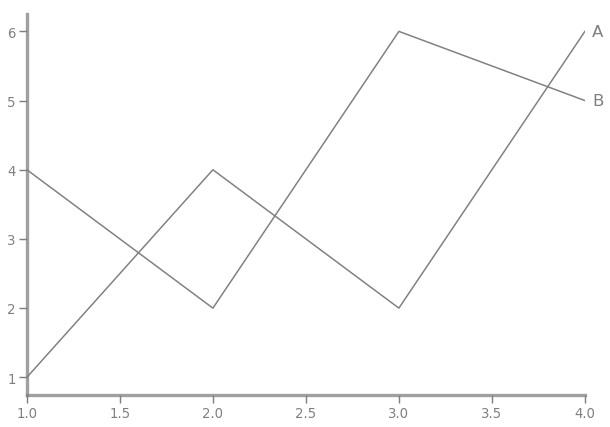

In [310]:
swm = SWMat(plt)

ls = swm.line_plot(np.array([[1, 2, 3, 4], [1, 2, 3, 4]]), np.array([[1, 4, 2, 6], [4, 2, 6, 5]]), line_labels=["A", "B"])
ax = plt.gca()
lbs = ax.get_xticks()
lbs

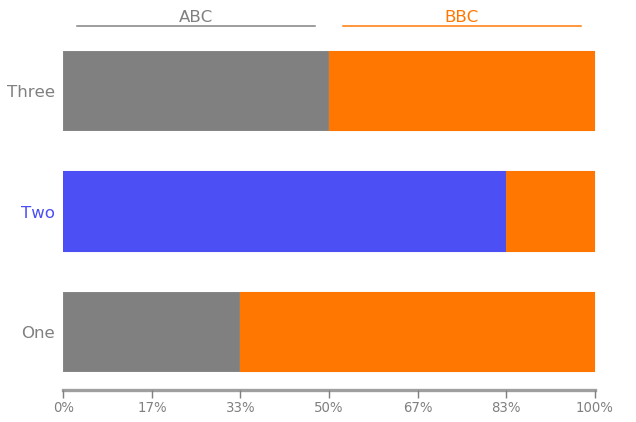

In [271]:
swm = SWMat(plt)
#swm.bar(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 3, 6], [2, 4, 2], [2, 4, 1]]), data_labels=["A", "B", "C", "D"], cat_labels=["One", "Two", "Three"])
#swm.bar(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 3, 6], [2, 4, 2]]), data_labels=["A", "B", "C"], cat_labels=["One", "Two", "Three"])
swm.bar(np.array([[1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 1, 3]]), data_labels=["ABC", "BBC"],  highlight={"data":1, "cat":1},
        cat_labels=["One", "Two", "Three"], plot_type="stacked100%", width=0.8);

In [247]:
import matplotlib.ticker as mtick
mtick.PercentFormatter()

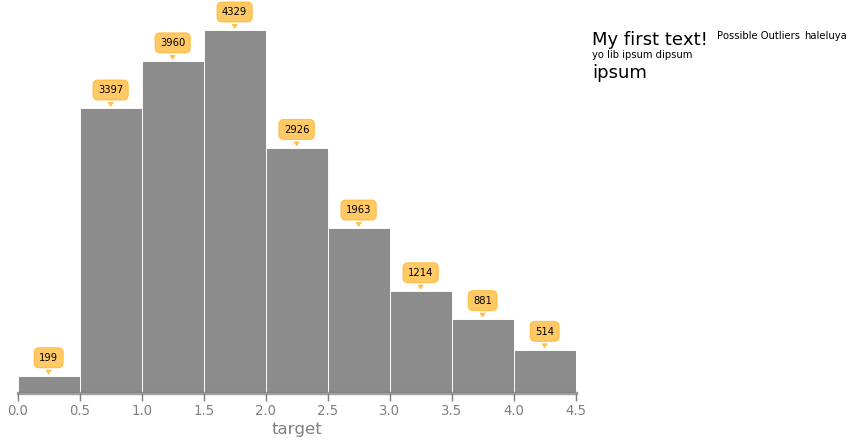

In [268]:
swm = SWMat(plt)
hist = swm.hist(train_df['target'], highlight=None, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5], ec='w', hide_y=True)
#plt.hist(train_df['target'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5], ec='w')
t = swm.text("My first text!<prop>Possible Outliers</prop><prop>haleluya\nyo lib ipsum dipsum</prop>\nipsum", 
             fontsize=18)
p = swm._ax.patches[0]
b = p.get_bbox()

In [ ]:
swm = SWMat(plt)
bar = swm.bar()
t = swm.text("My first text!<prop>Possible Outliers</prop><prop>haleluya\nyo lib ipsum dipsum</prop>\nipsum", 
             fontsize=18)